# Understanding FLOPS Calculation for Qwen2.5 Models

This notebook provides a detailed explanation of how we calculate Floating Point Operations (FLOPS) for the Qwen2.5 model architecture with LoRA fine-tuning. FLOPS counting is crucial for estimating computational requirements and adhering to the 10^17 FLOPS budget specified in the coursework.

## Key Components

The Qwen2.5-0.5B model architecture consists of:
- 24 transformer layers
- 896 hidden dimensions
- 14 attention heads
- 64 head dimensions
- 4864 feed-forward network dimensions
- 151936 vocabulary size
- 128 attention dimensions

Our FLOPS calculator accounts for operations in:
1. Multi-head attention (MHA)
2. RMSNorm layer normalization
3. Feed-forward network (FFN)
4. Residual connections
5. LoRA adaptations (during training)
6. Language model head
7. Loss calculation

## Defining Operation Costs

Based on the coursework specification, we count FLOPS with the following operation costs:

In [1]:
import sys
import os
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Add the src directory to the path to import the QwenFlopsCalculator
sys.path.append(os.path.join(os.path.dirname(os.path.abspath("")), 'src'))
from get_flops import QwenFlopsCalculator, OperationFlops

# Create a flops calculator instance
flops_calculator = QwenFlopsCalculator()

# Display the operation costs
@dataclass
class OperationFlops:
    """
    FLOPs for different operations as specified in the coursework:
        Additions, Subtractions, Negations: 1
        Multiplications, Divisions, Inverses: 1
        ReLU, Absolute Value: 1
        Exponentiation, Logarithm: 10
        Sine, Cosine, Square Root: 10
    """
    _ADD: int = 1
    _SUB: int = 1
    _NEG: int = 1
    _MUL: int = 1
    _DIV: int = 1
    _INV: int = 1
    _RELU: int = 1
    _ABS: int = 1
    _EXP: int = 10
    _LOG: int = 10
    _SIN: int = 10
    _COS: int = 10
    _SQRT: int = 10

print("Operation FLOPS costs used in calculations:")
for attr_name, attr_value in OperationFlops().__dict__.items():
    if attr_name.startswith('_'):
        print(f"{attr_name[1:]:10} : {attr_value} FLOPS")

Operation FLOPS costs used in calculations:
ADD        : 1 FLOPS
SUB        : 1 FLOPS
NEG        : 1 FLOPS
MUL        : 1 FLOPS
DIV        : 1 FLOPS
INV        : 1 FLOPS
RELU       : 1 FLOPS
ABS        : 1 FLOPS
EXP        : 10 FLOPS
LOG        : 10 FLOPS
SIN        : 10 FLOPS
COS        : 10 FLOPS
SQRT       : 10 FLOPS


## Model Architecture Parameters

The Qwen2.5-0.5B model has these specific architecture parameters:

In [2]:
print(f"Model Architecture Parameters:")
print(f"{'Number of layers:':30} {flops_calculator.num_layers}")
print(f"{'Hidden dimension:':30} {flops_calculator.hidden_dim}")
print(f"{'Number of attention heads:':30} {flops_calculator.num_heads}")
print(f"{'Head dimension:':30} {flops_calculator.head_dim}")
print(f"{'Feed-forward dimension:':30} {flops_calculator.ffn_dim}")
print(f"{'Vocabulary size:':30} {flops_calculator.vocab_size}")
print(f"{'Attention dimension:':30} {flops_calculator.attention_dim}")

Model Architecture Parameters:
Number of layers:              24
Hidden dimension:              896
Number of attention heads:     14
Head dimension:                64
Feed-forward dimension:        4864
Vocabulary size:               151936
Attention dimension:           128


## 1. Multi-head Attention FLOPS

Now let's examine how FLOPS are calculated for the multi-head attention mechanism.
The calculation includes:

1. Query, Key, and Value projections 
2. Rotary positional embedding application （simplified - only accounting for the flops of addition)
3. Attention scores (QK^T) computation
4. Scaling and softmax operations
5. Attention application to values
6. Output projection

Let's use a small example with batch_size=1 and seq_len=32:

In [3]:
batch_size = 1
seq_len = 32
verbose = True

attention_flops, attention_breakdown = flops_calculator.get_attention_flops(
    batch_size, seq_len, verbose
)

print(attention_breakdown)
print(f"Total Attention FLOPS: {attention_flops:,}")

Attention FLOPs Breakdown:
    QKV Projection:        308,281,344 FLOPs - Matrix multiplication to project embeddings to QKV
    Rotary Embedding:      114,688 FLOPs - Applying rotary position embeddings to Q and K
    QK^T Multiplication:   3,655,680 FLOPs - Computing attention scores via Q*K^T
    Attention Maps:        14,336 FLOPs - Adding attention maps across heads
    Scaling:               14,476 FLOPs - Dividing by sqrt(attention_dim)
    Softmax:               171,584 FLOPs - Computing softmax for attention weights
    Attention*V:           3,655,680 FLOPs - Applying attention weights to values
    Output Projection:     102,731,776 FLOPs - Projecting attention outputs back to hidden dimension
    --- 
    Total Attention FLOPs: 418,639,564

Total Attention FLOPS: 418,639,564


## 2. RMSNorm FLOPS

Next, we'll look at RMSNorm (Root Mean Square Normalization) used in Qwen2.5 instead of LayerNorm.
The calculation includes:

1. Calculating variance (squared mean) 
2.  Applying normalization factor (1/sqrt(variance + epsilon))
3. Scaling with learnable weights


In [4]:
rmsnorm_flops, rmsnorm_breakdown = flops_calculator.get_RMSNorm_flops(
    batch_size, seq_len, verbose
)

print(rmsnorm_breakdown)
print(f"Total RMSNorm FLOPS: {rmsnorm_flops:,}")

RMSNorm FLOPs Breakdown:
    Variance Calculation:  57,344 FLOPs - Computing squared mean for normalization
    Normalization:         29,056 FLOPs - Applying normalization factor to hidden states
    Weight Application:    28,672 FLOPs - Applying learnable weight parameters
    ---
    Total RMSNorm FLOPs:   115,072

Total RMSNorm FLOPS: 115,072


## 3. Feed-Forward Network FLOPS

The FFN in Qwen2.5 uses a SwiGLU activation and includes:

1. Gate projection with SiLU activation
2. Up projection
3. Element-wise multiplication of gate and up projections
4. Down projection

In [5]:
ffn_flops, ffn_breakdown = flops_calculator.get_ffn_flops(
    batch_size, seq_len, verbose
)

print(ffn_breakdown)
print(f"Total FFN FLOPS: {ffn_flops:,}")

FFN FLOPs Breakdown:
    Gate Projection:       280,944,640 FLOPs - Projecting to gating dimension with SiLU activation
    Up Projection:         278,765,568 FLOPs - Projecting to intermediate dimension
    Gated Multiplication:  155,648 FLOPs - Element-wise multiplication of gate and up projections
    Down Projection:       278,892,544 FLOPs - Projecting back to hidden dimension
    ---
    Total FFN FLOPs:       838,758,400

Total FFN FLOPS: 838,758,400


## 4. LoRA Adaptation FLOPS

For our fine-tuning, we use LoRA adaptations which add computations:

1. Down-projection to low-rank space
2. Up-projection to original dimensionality
3. Scaling and addition to original weights

Let's see the FLOPS for LoRA with rank=4:

In [6]:
lora_rank = 4
lora_flops, lora_breakdown = flops_calculator.get_lora_flops(
    batch_size, seq_len, lora_rank, verbose
)

print(lora_breakdown)
print(f"Total LoRA FLOPS (per layer where applied): {lora_flops:,}")

LoRA FLOPs Breakdown:
    Down Projection:       229,248 FLOPs - Projecting to low-rank dimension
    Up Projection:         28,672 FLOPs - Projecting from low-rank to attention dimension
    Scaling Coefficient:   4,097 FLOPs - Scaling coefficient for LoRA output
    Addition to Output:    4,096 FLOPs - Adding LoRA output to original output
    ---
    Total LoRA FLOPs:      266,113

Total LoRA FLOPS (per layer where applied): 266,113


## 5. Language Model Head FLOPS

The language model head projects from hidden states to vocabulary size:

In [7]:
lm_head_flops, lm_head_breakdown = flops_calculator.get_LM_head(
    batch_size, seq_len, verbose
)

print(lm_head_breakdown)
print(f"Total LM Head FLOPS: {lm_head_flops:,}")

LM Head FLOPs Breakdown:
    LM Head Projection:    272,269,312 FLOPs - Projecting hidden states to vocabulary size
    ---
    Total LM Head FLOPs:   272,269,312

Total LM Head FLOPS: 272,269,312


## 6. Loss Calculation FLOPS

For training, we need to compute the loss:

In [8]:
loss_flops, loss_breakdown = flops_calculator.get_loss_flops(
    batch_size, seq_len, verbose
)

print(loss_breakdown)
print(f"Total Loss Calculation FLOPS: {loss_flops:,}")

Loss FLOPs Breakdown:
    Softmax:               58,343,424 FLOPs - Computing softmax for loss calculation
    Log and Time:          352 FLOPs - Computing log and multiply by true label
    ---
    Total Loss FLOPs:      58,343,776

Total Loss Calculation FLOPS: 58,343,776


## 7. Residual Connection FLOPS

Simple residual connections that add the input to the output:

In [9]:
residual_flops, residual_breakdown = flops_calculator.get_residual_flops(
    batch_size, seq_len, verbose
)

print(residual_breakdown)
print(f"Total Residual Connection FLOPS: {residual_flops:,}")

Residual FLOPs Breakdown:
    Residual Addition:     28,672 FLOPs - Adding residual connection to layer output
    ---
    Total Residual FLOPs:  28,672

Total Residual Connection FLOPS: 28,672


## Full Model FLOPS Breakdown

Now let's see the full model FLOPS calculation, including both training and inference:

In [10]:
# Training FLOPS
training_flops = flops_calculator.get_flops(
    batch_size, seq_len, lora_rank, verbose=True, inference=False
)

print(f"\nTotal Training FLOPS: {training_flops:,}")

# Inference FLOPS
inference_flops = flops_calculator.get_flops(
    batch_size, seq_len, lora_rank, verbose=False, inference=True
)

print(f"\nTotal Inference FLOPS: {inference_flops:,}")
print(f"Training/Inference FLOPS ratio: {training_flops / inference_flops:.2f}x")


=== QWEN 2.5 FLOPs Calculation ===

==== Component Breakdown ====
Attention FLOPs Breakdown:
    QKV Projection:        308,281,344 FLOPs - Matrix multiplication to project embeddings to QKV
    Rotary Embedding:      114,688 FLOPs - Applying rotary position embeddings to Q and K
    QK^T Multiplication:   3,655,680 FLOPs - Computing attention scores via Q*K^T
    Attention Maps:        14,336 FLOPs - Adding attention maps across heads
    Scaling:               14,476 FLOPs - Dividing by sqrt(attention_dim)
    Softmax:               171,584 FLOPs - Computing softmax for attention weights
    Attention*V:           3,655,680 FLOPs - Applying attention weights to values
    Output Projection:     102,731,776 FLOPs - Projecting attention outputs back to hidden dimension
    --- 
    Total Attention FLOPs: 418,639,564

RMSNorm FLOPs Breakdown:
    Variance Calculation:  57,344 FLOPs - Computing squared mean for normalization
    Normalization:         29,056 FLOPs - Applying normalizati

## FLOPS Scaling with Different Parameters

Let's analyze how FLOPS scale with different parameters:

1. Sequence length
2. Batch size
3. LoRA rank

For better visualization, the FLOPS are log-scaled. To interpret the values on the y-axis, note that the FLOPS value is $10^{y_{value}}$. This scaling helps to visualize how close each operation is to our budget of $10^{17}$ FLOPS.


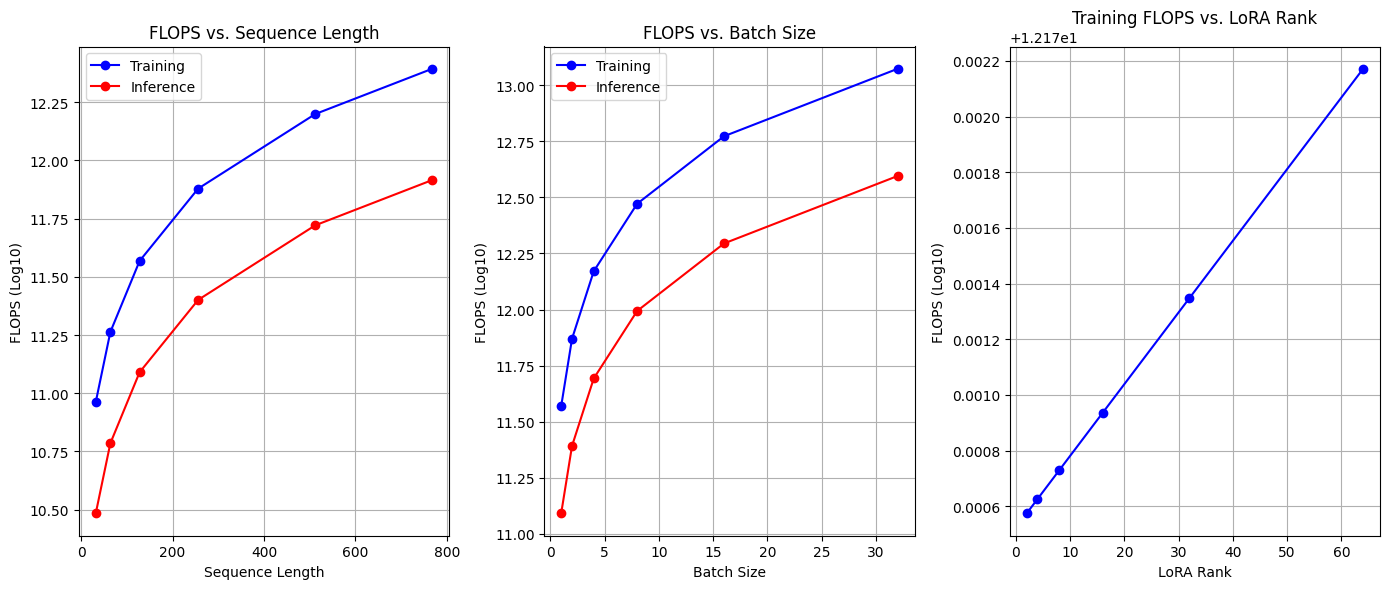

In [15]:
# Sequence length scaling
seq_lengths = [32, 64, 128, 256, 512, 768]
train_flops_by_seq = [flops_calculator.get_flops(1, sl, 4, inference=False) for sl in seq_lengths]
infer_flops_by_seq = [flops_calculator.get_flops(1, sl, 4, inference=True) for sl in seq_lengths]

plt.figure(figsize=(14, 6))

plt.subplot(1, 3, 1)
plt.plot(seq_lengths, [np.log10(f) for f in train_flops_by_seq], 'b-o', label='Training')
plt.plot(seq_lengths, [np.log10(f) for f in infer_flops_by_seq], 'r-o', label='Inference')
plt.xlabel('Sequence Length')
plt.ylabel('FLOPS (Log10)')
plt.title('FLOPS vs. Sequence Length')
plt.legend()
plt.grid(True)

# Batch size scaling
batch_sizes = [1, 2, 4, 8, 16, 32]
train_flops_by_batch = [flops_calculator.get_flops(bs, 128, 4, inference=False) for bs in batch_sizes]
infer_flops_by_batch = [flops_calculator.get_flops(bs, 128, 4, inference=True) for bs in batch_sizes]

plt.subplot(1, 3, 2)
plt.plot(batch_sizes, [np.log10(f) for f in train_flops_by_batch], 'b-o', label='Training')
plt.plot(batch_sizes, [np.log10(f) for f in infer_flops_by_batch], 'r-o', label='Inference')
plt.xlabel('Batch Size')
plt.ylabel('FLOPS (Log10)')
plt.title('FLOPS vs. Batch Size')
plt.legend()
plt.grid(True)

# LoRA rank scaling
lora_ranks = [2, 4, 8, 16, 32, 64]
train_flops_by_rank = [flops_calculator.get_flops(4, 128, r, inference=False) for r in lora_ranks]

plt.subplot(1, 3, 3)
plt.plot(lora_ranks, [np.log10(f) for f in train_flops_by_rank], 'b-o')
plt.xlabel('LoRA Rank')
plt.ylabel('FLOPS (Log10)')
plt.title('Training FLOPS vs. LoRA Rank')
plt.grid(True)

plt.tight_layout()
plt.show()

## Budget Planning Analysis

Given our 10^17 FLOPS budget, let's analyze how many training iterations we can afford for different configurations:

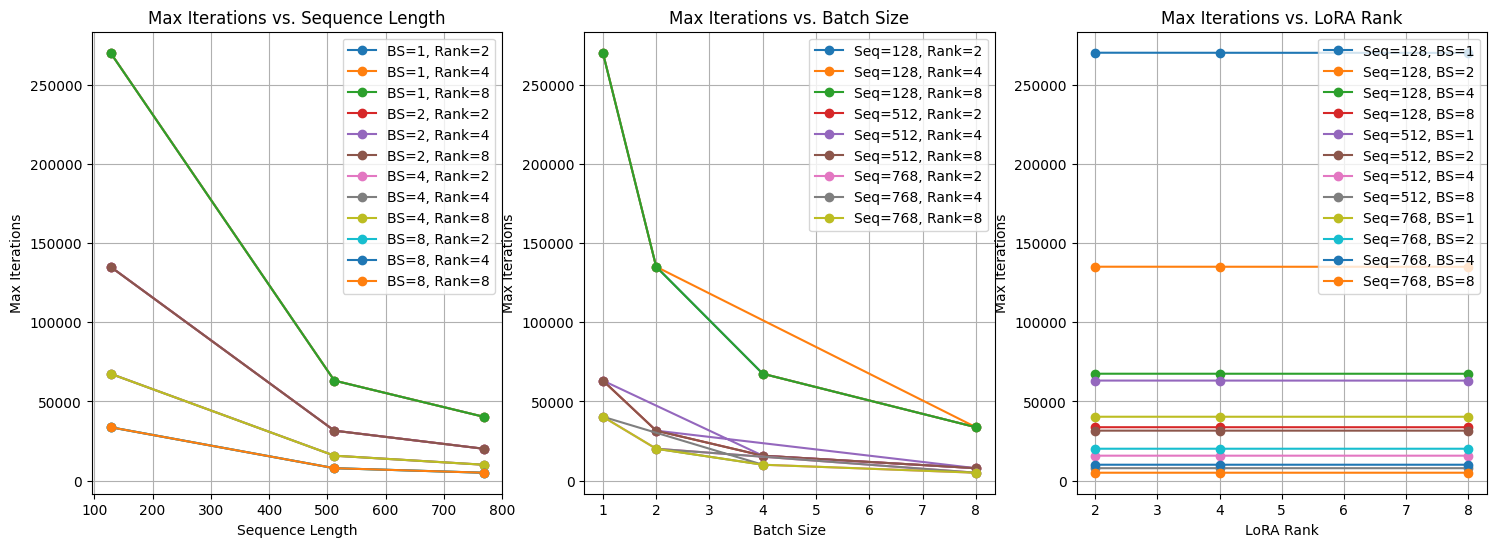

In [25]:
from IPython.display import HTML
from pandas.io.formats.style import Styler

# Create a grid of configurations
configs = []
for seq_len in [128, 512, 768]:
    for batch_size in [1, 2, 4, 8]:
        for lora_rank in [2, 4, 8]:
            flops = flops_calculator.get_flops(batch_size, seq_len, lora_rank, inference=False)
            iterations = int(1e17 / flops)  # How many iterations fit in our budget
            configs.append({
                "seq_len": seq_len,
                "batch_size": batch_size,
                "lora_rank": lora_rank,
                "flops_per_iter": flops,
                "max_iterations": iterations,
                "tokens_processed": iterations * batch_size * seq_len
            })

# Convert to DataFrame for easier analysis
df = pd.DataFrame(configs)
df = df.sort_values("tokens_processed", ascending=False)

# Create a more informative interactive visualization
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# 1. Iterations vs Sequence Length by Batch Size
for bs in [1, 2, 4, 8]:
    subset = df[df["batch_size"] == bs]
    for rank in [2, 4, 8]:
        axs[0].plot(subset[subset["lora_rank"] == rank]["seq_len"], 
                    subset[subset["lora_rank"] == rank]["max_iterations"],
                    marker='o', label=f"BS={bs}, Rank={rank}")
axs[0].set_xlabel('Sequence Length')
axs[0].set_ylabel('Max Iterations')
axs[0].set_title('Max Iterations vs. Sequence Length')
axs[0].grid(True)
axs[0].legend(loc='best')


# 2. Iterations vs Batch Size by Sequence Length
for sl in [128, 512, 768]:
    subset = df[df["seq_len"] == sl]
    for rank in [2, 4, 8]:
        axs[1].plot(subset[subset["lora_rank"] == rank]["batch_size"], 
                    subset[subset["lora_rank"] == rank]["max_iterations"],
                    marker='o', label=f"Seq={sl}, Rank={rank}")
axs[1].set_xlabel('Batch Size')
axs[1].set_ylabel('Max Iterations')
axs[1].set_title('Max Iterations vs. Batch Size')
axs[1].grid(True)
axs[1].legend(loc='best')

# 3. Iterations vs LoRA Rank by Sequence Length
for sl in [128, 512, 768]:
    subset = df[df["seq_len"] == sl]
    for bs in [1, 2, 4, 8]:
        axs[2].plot(subset[subset["batch_size"] == bs]["lora_rank"], 
                    subset[subset["batch_size"] == bs]["max_iterations"],
                    marker='o', label=f"Seq={sl}, BS={bs}")
axs[2].set_xlabel('LoRA Rank')
axs[2].set_ylabel('Max Iterations')
axs[2].set_title('Max Iterations vs. LoRA Rank')
axs[2].grid(True)
axs[2].legend(loc='best')

#

# Create an interactive table showing the tradeoff between parameters

# Highlight the table based on max_iterations
def highlight_max_iterations(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styled_df = df.style.apply(highlight_max_iterations, subset=['max_iterations'])
styled_df = styled_df.format({
    'flops_per_iter': '{:,.0f}',
    'max_iterations': '{:,.0f}',
})

display(HTML("<h3>Configuration Trade-offs (sorted by max iterations)</h3>"))
display(df.sort_values("max_iterations", ascending=False).head(15).style.format({
    'flops_per_iter': '{:,.0f}',
    'max_iterations': '{:,.0f}',
}))

Now for the inference FLOPS calculation, we can use the same formula as the training FLOPS calculation, but with the following modifications:
- **no LoRA Flops**, since LoRA can be merged back into the model weights before inference, and the model weights can be used directly for inference
- **no loss function calculation Flops**, since we don't need to calculate the loss during inference
- **no gradient calculation Flops**, since we don't need to calculate gradients during inference


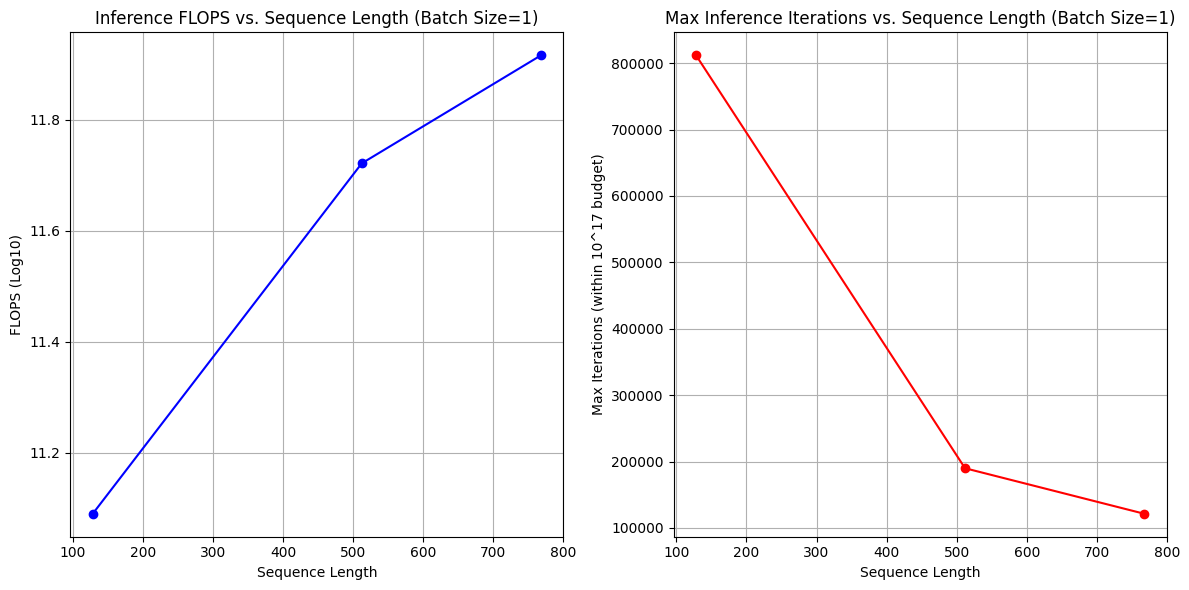


Inference configurations with batch size=1:


In [27]:
from IPython.display import HTML
import matplotlib.pyplot as plt
import pandas as pd

# Create configurations for inference at selected sequence lengths
seq_lengths = [128, 512, 768]
batch_size = 1  # Fixed batch size of 1

# Create configurations for inference
configs = []
for seq_len in seq_lengths:
    # For inference, we don't use LoRA as it can be merged with weights
    flops = flops_calculator.get_flops(batch_size, seq_len, 0, inference=True)
    iterations = int(1e17 / flops)  # How many iterations fit in our budget
    configs.append({
        "seq_len": seq_len,
        "flops_per_iter": flops,
        "max_iterations": iterations,
        "tokens_processed": iterations * batch_size * seq_len
    })

# Convert to DataFrame for analysis
df_inference = pd.DataFrame(configs)
df_inference = df_inference.sort_values("tokens_processed", ascending=False)

# Create a visualization of inference FLOPS scaling
plt.figure(figsize=(12, 6))

# Plot 1: FLOPS vs Sequence Length
plt.subplot(1, 2, 1)
plt.plot(df_inference["seq_len"], [np.log10(f) for f in df_inference["flops_per_iter"]], 
         marker='o', color='blue')
plt.xlabel('Sequence Length')
plt.ylabel('FLOPS (Log10)')
plt.title('Inference FLOPS vs. Sequence Length (Batch Size=1)')
plt.grid(True)

# Plot 2: Max Iterations vs Sequence Length
plt.subplot(1, 2, 2)
plt.plot(df_inference["seq_len"], df_inference["max_iterations"], marker='o', color='red')
plt.xlabel('Sequence Length')
plt.ylabel('Max Iterations (within 10^17 budget)')
plt.title('Max Inference Iterations vs. Sequence Length (Batch Size=1)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display table of configurations
print("\nInference configurations with batch size=1:")
display(df_inference.style.format({
    'flops_per_iter': '{:,.0f}',
    'max_iterations': '{:,.0f}',
}))


Now, give some stats on the `flops_per_iter` and `max_iterations` for the inference and training FLOPs calculation, I have gotten a sense of how many iterations we can afford for different configurations. Thus helping us to plan our budget effectively.

## Conclusion

This notebook provided a detailed explanation of how we calculate FLOPS for the Qwen2.5-0.5B model with LoRA fine-tuning. The key insights are:

1. **Component-wise breakdown**: We analyzed FLOPS for each architectural component
2. **Scaling behavior**: We showed how FLOPS scale with sequence length, batch size, and LoRA rank
3. **Budget planning**: We examined how to optimize configurations within our FLOPS budget
4. **Experiment accounting**: We demonstrated how to track FLOPS for complete experiments

This understanding allows us to:
1. Plan experiments efficiently within our computational budget
2. Make informed trade-offs between hyperparameters
3. Report accurate FLOPS usage as required by the coursework

The implementation in `get_flops.py` enables us to track and log FLOPS throughout our training and evaluation processes.